In [1]:
import json
import numpy as np
import networkx as nx
from collections import defaultdict, Counter
from typing import Dict, List, Tuple
import os
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

# For embeddings and similarity computation
try:
    from sentence_transformers import SentenceTransformer
    from sklearn.metrics.pairwise import cosine_similarity
    print("Required libraries imported successfully!")
except ImportError as e:
    print(f"Missing library: {e}")
    print("Please install with: pip install sentence-transformers scikit-learn networkx")

np.random.seed(42)

Required libraries imported successfully!


In [2]:
from scipy.sparse import find, csr_matrix
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import norm
from IPython.core.display import HTML

# des options permettent de limiter (ou non) le nombre de lignes/colonnes affichées
# par exemple :
# pd.set_option('display.max_rows', None)

# cette fonction permet d'afficher une "jolie" représentation du vecteur v
# ARGS :
#   v : le vecteur à afficher (par ex. une ligne de la matrice X)
#   features : le vocabulaire
#   top_n : le nombre de mots maximum à afficher
def print_feats(v, features, top_n = 30):
    _, ids, values = find(v)
    feats = [(ids[i], values[i], features[ids[i]]) for i in range(len(list(ids)))]
    top_feats = sorted(feats, key=lambda x: x[1], reverse=True)[0:top_n]
    return pd.DataFrame({"word" : [t[2] for t in top_feats], "value": [t[1] for t in top_feats]})   

# fonction qui permet d'afficher plusieurs tables pandas côte à côte (c'est cadeau)
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "&emsp;"
        #output += "\xa0\xa0\xa0"
    display(HTML(output))

In [3]:
def load_corpus(file_path: str) -> Dict[str, Dict]:
    """
    Load corpus data from JSONL file.
    Returns dictionary mapping document IDs to document data.
    """
    out_dict = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data = json.loads(line)
            id = data['_id']
            del data['_id']
            out_dict[id] = data 
    return out_dict
   
def load_queries(file_path: str) -> Dict[str, Dict]:
    """
    Load query data from JSONL file.
    Returns dictionary mapping query IDs to query data.
    """
    out_dict = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data = json.loads(line)
            id = data['_id']
            del data['_id']
            out_dict[id] = data 
    return out_dict

def load_qrels(file_path: str) -> Dict[str, Dict[str, int]]:
    """    
    Load relevance judgments from TSV file.
    Returns dictionary mapping query IDs to candidate relevance scores.
    """
    data = pd.read_csv(file_path, sep = '\t')
    out = {
    query_id: {r['corpus-id']: r['score'] for _, r in grp.iterrows()}
    for query_id, grp in data.groupby('query-id')
    }
    return out
    

In [4]:
file_path_corpus = "dataset_BE2/corpus.jsonl"
corpus = load_corpus(file_path_corpus)

file_path_query = "dataset_BE2/queries.jsonl"
queries = load_queries(file_path_query)

file_path_qrels = "dataset_BE2/valid.tsv"
qrels = load_qrels(file_path_qrels)

In [5]:
titles = []
for key, dic in corpus.items():
    title = dic['title']
    titles.append(title)

In [6]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit(titles)

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"
,analyzer,'word'


In [7]:
titles_matrix = count_vectorizer.transform(titles)

In [8]:
titles_matrix.shape

(25657, 20075)

In [9]:
count_vectorizer.vocabulary_

{'hybrid': 8630,
 'of': 12584,
 'genetic': 7657,
 'algorithm': 948,
 'and': 1149,
 'particle': 13193,
 'swarm': 17668,
 'optimization': 12764,
 'for': 7259,
 'recurrent': 15022,
 'network': 12138,
 'design': 5077,
 'ep': 6303,
 'sqp': 17031,
 'dynamic': 5750,
 'economic': 5852,
 'dispatch': 5401,
 'with': 19810,
 'nonsmooth': 12374,
 'fuel': 7464,
 'cost': 4266,
 'function': 7473,
 'fuzzy': 7506,
 'systems': 17771,
 'evolutionary': 6513,
 'tuning': 18718,
 'learning': 10101,
 'knowledge': 9865,
 'bases': 1981,
 'modified': 11480,
 'optimizer': 12768,
 'identification': 8770,
 'control': 4113,
 'using': 19116,
 'neural': 12144,
 'networks': 12141,
 'separate': 16211,
 'face': 6749,
 'body': 2429,
 'selectivity': 16131,
 'on': 12648,
 'the': 18107,
 'fusiform': 7496,
 'gyrus': 8062,
 'scheduling': 15917,
 'reduced': 15041,
 'cpu': 4327,
 'energy': 6211,
 'data': 4675,
 'mining': 11343,
 'approach': 1352,
 'location': 10384,
 'prediction': 14075,
 'in': 8947,
 'mobile': 11441,
 'environme

In [10]:
features = count_vectorizer.get_feature_names_out()

for i in range(2):
    print(f"\n==== Document {i} ====")
    display(print_feats(titles_matrix[i], features))


==== Document 0 ====


,word,value
0,algorithm,1
1,and,1
2,design,1
3,for,1
4,genetic,1
5,hybrid,1
6,network,1
7,of,1
8,optimization,1
9,particle,1



==== Document 1 ====


,word,value
0,and,1
1,cost,1
2,dispatch,1
3,dynamic,1
4,economic,1
5,ep,1
6,for,1
7,fuel,1
8,function,1
9,hybrid,1


<Axes: xlabel='word'>

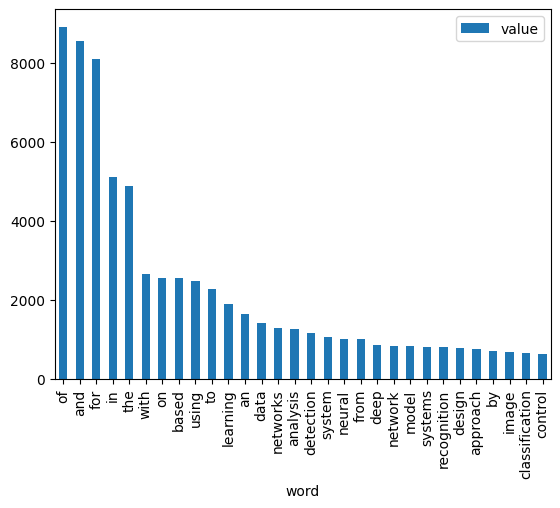

In [11]:
print_feats(titles_matrix.sum(axis=0),count_vectorizer.get_feature_names_out()).plot.bar(x='word',y='value')

In [12]:
cos_similarities = cosine_similarity(titles_matrix)

In [13]:
queries_texts = []
for id, dic in queries.items():
    text = dic['text']
    queries_texts.append(text)

In [14]:
queries_matrix = count_vectorizer.transform(queries_texts)

In [15]:
queries_matrix.shape

(1000, 20075)

In [16]:
distances = []
query = queries_matrix[0].toarray()
for i in range(titles_matrix.shape[0]):
    x = titles_matrix[i].toarray()
    dist = cosine_similarity(query,x)
    distances.append(dist)

In [17]:
distances = np.array(distances).flatten()

In [18]:
returns = count_vectorizer.inverse_transform(titles_matrix[np.flip(np.argsort(distances))[:10]])

In [19]:
for title in returns:
    print(' '.join(title))

direct golden hyper method over rectangle search section
generator get networks point pointer summarization the to with
algorithm approach cuckoo metaheuristic optimization problems search solve structural to
capability dynamic evolutionary learning problem routing search solving vehicle via with
accuracy history improve long mining search term to
inexact perceptron search structured with
direct of point sets visibility
guide search tabu to user
attention details styling to with
2v 341gb 64gb and bank control data dram group hbm2 improved point spiral stacked structure to tsv with


Avec TFxIDF

In [20]:
tfid_vectorizer = TfidfVectorizer()
tfid_vectorizer.fit(titles)

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,analyzer,'word'
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"


In [21]:
titles_matrix = tfid_vectorizer.transform(titles)
queries_matrix = tfid_vectorizer.transform(queries_texts)

In [22]:
distances = []
query = queries_matrix[0].toarray()
for i in range(titles_matrix.shape[0]):
    x = titles_matrix[i].toarray()
    dist = cosine_similarity(query,x)
    distances.append(dist)

In [23]:
distances = np.array(distances).flatten()
returns = count_vectorizer.inverse_transform(titles_matrix[np.flip(np.argsort(distances))[:10]])
for title in returns:
    print(' '.join(title))

dispatch distributed economic event for grids in scheme smart triggered
considering cost dispatch economic energy for functions microgrid renewable
and cost dispatch dynamic economic ep for fuel function hybrid nonsmooth sqp with
direct of point sets visibility
direct golden hyper method over rectangle search section
algorithm approach cuckoo metaheuristic optimization problems search solve structural to
analyzing mutation of operators performance problem salesman solve the to travelling
as coded correspondence in light problem progress recent solve structured survey technique the to
and development diversity economic network
intermediate math problems representations solve to using word


Sentence-transformers

In [24]:
def build_doc_text(doc):
    title = doc.get("title", "")
    abstract = doc.get("abstract", "")
    return (title or "") + " " + (abstract or "")

corpus_ids = list(corpus.keys())
corpus_texts = [build_doc_text(corpus[doc_id]) for doc_id in corpus_ids]

query_ids = list(queries.keys())
query_texts = [queries[q_id].get("text", "") for q_id in query_ids]

In [25]:
emb_dir = "embeddings"
os.makedirs(emb_dir, exist_ok=True)

# List of models to compare
models_to_compare = [
    "all-MiniLM-L6-v2",
    "paraphrase-MiniLM-L6-v2",
    "all-mpnet-base-v2"
]

embeddings_data = {}

for model_name in models_to_compare:
    corpus_emb_path = os.path.join(emb_dir, f"corpus_embeddings_{model_name}.npy")
    query_emb_path = os.path.join(emb_dir, f"query_embeddings_{model_name}.npy")
    corpus_ids_path = os.path.join(emb_dir, f"corpus_ids_{model_name}.pkl")
    query_ids_path = os.path.join(emb_dir, f"query_ids_{model_name}.pkl")

    if os.path.exists(corpus_emb_path) and os.path.exists(query_emb_path):
        print(f"Loading existing embeddings for {model_name}...")
        corpus_embeddings = np.load(corpus_emb_path)
        query_embeddings = np.load(query_emb_path)
        
        with open(corpus_ids_path, "rb") as f:
            corpus_ids_loaded = pickle.load(f)
        with open(query_ids_path, "rb") as f:
            query_ids_loaded = pickle.load(f)
    else:
        print(f"Computing embeddings with {model_name}...")
        model = SentenceTransformer(model_name)
        
        corpus_embeddings = model.encode(
            corpus_texts,
            batch_size=64,
            show_progress_bar=True,
            convert_to_numpy=True,
            normalize_embeddings=True
        )
        
        query_embeddings = model.encode(
            query_texts,
            batch_size=64,
            show_progress_bar=True,
            convert_to_numpy=True,
            normalize_embeddings=True
        )
        
        np.save(corpus_emb_path, corpus_embeddings)
        np.save(query_emb_path, query_embeddings)
        with open(corpus_ids_path, "wb") as f:
            pickle.dump(corpus_ids, f)
        with open(query_ids_path, "wb") as f:
            pickle.dump(query_ids, f)

    embeddings_data[model_name] = {
        'corpus_embeddings': corpus_embeddings,
        'query_embeddings': query_embeddings,
        'corpus_ids': corpus_ids,
        'query_ids': query_ids
    }

    print(f"{model_name} - Corpus embeddings shape: {corpus_embeddings.shape}")
    print(f"{model_name} - Query embeddings shape: {query_embeddings.shape}")
    print()

Computing embeddings with all-MiniLM-L6-v2...


Batches: 100%|██████████| 16/16 [00:00<00:00, 51.05it/s]


all-MiniLM-L6-v2 - Corpus embeddings shape: (25657, 384)
all-MiniLM-L6-v2 - Query embeddings shape: (1000, 384)

Computing embeddings with paraphrase-MiniLM-L6-v2...


Batches: 100%|██████████| 16/16 [00:00<00:00, 40.83it/s]


paraphrase-MiniLM-L6-v2 - Corpus embeddings shape: (25657, 384)
paraphrase-MiniLM-L6-v2 - Query embeddings shape: (1000, 384)

Computing embeddings with all-mpnet-base-v2...


Batches: 100%|██████████| 16/16 [00:01<00:00, 10.19it/s]

all-mpnet-base-v2 - Corpus embeddings shape: (25657, 768)
all-mpnet-base-v2 - Query embeddings shape: (1000, 768)



In [26]:
corpus_index = {doc_id: idx for idx, doc_id in enumerate(corpus_ids)}
query_index = {q_id: idx for idx, q_id in enumerate(query_ids)}

def search_with_embeddings(query_text, top_k=10):
    model = SentenceTransformer(model_name)
    q_emb = model.encode([query_text], normalize_embeddings=True)
    sims = cosine_similarity(q_emb, corpus_embeddings)[0]
    top_idx = np.argsort(-sims)[:top_k]
    
    results = []
    for i in top_idx:
        doc_id = corpus_ids[i]
        score = sims[i]
        title = corpus[doc_id].get("title", "")
        results.append((doc_id, score, title))
    return results

example_qid = query_ids[0]
example_qidx = query_index[example_qid]
example_qemb = query_embeddings[example_qidx].reshape(1, -1)

sims = cosine_similarity(example_qemb, corpus_embeddings)[0]
top_idx = np.argsort(-sims)[:10]

In [27]:
from sklearn.metrics import roc_auc_score

def evaluate_dense_search(qrels, corpus_embeddings, query_embeddings, corpus_ids, query_ids, top_k=5):
    corpus_index = {doc_id: idx for idx, doc_id in enumerate(corpus_ids)}
    query_index = {q_id: idx for idx, q_id in enumerate(query_ids)}
    
    precisions = []
    recalls = []
    f1s = []
    aucs = []

    for qid, cand_dict in qrels.items():
        if qid not in query_index:
            continue
        
        qidx = query_index[qid]
        q_emb = query_embeddings[qidx].reshape(1, -1)

        candidate_ids = list(cand_dict.keys())
        
        candidate_ids = [cid for cid in candidate_ids if cid in corpus_index]
        if len(candidate_ids) == 0:
            continue
        
        cand_indices = [corpus_index[cid] for cid in candidate_ids]
        cand_embs = corpus_embeddings[cand_indices]

        sims = cosine_similarity(q_emb, cand_embs)[0]
        y_true = np.array([cand_dict[cid] for cid in candidate_ids])  # 0 or 1
        
        order = np.argsort(-sims)
        sims_sorted = sims[order]
        y_sorted = y_true[order]
        
        k = min(top_k, len(y_sorted))
        y_pred_bin = np.zeros_like(y_sorted)
        y_pred_bin[:k] = 1
        
        tp = (y_pred_bin[:k] * y_sorted[:k]).sum()
        nb_pos = y_sorted.sum()
        
        if k > 0:
            prec = tp / k
        else:
            prec = 0.0
        
        if nb_pos > 0:
            rec = tp / nb_pos
        else:
            rec = 0.0
        
        if prec + rec > 0:
            f1 = 2 * prec * rec / (prec + rec)
        else:
            f1 = 0.0
        
        if nb_pos > 0 and nb_pos < len(y_sorted):
            try:
                auc = roc_auc_score(y_sorted, sims_sorted)
                aucs.append(auc)
            except ValueError:
                pass
        
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)

    results = {
        "precision{}".format(top_k): np.mean(precisions) if precisions else 0.0,
        "recall{}".format(top_k): np.mean(recalls) if recalls else 0.0,
        "f1{}".format(top_k): np.mean(f1s) if f1s else 0.0,
        "AUC_mean": np.mean(aucs) if aucs else 0.0
    }
    return results

In [28]:
# Evaluate and compare all models
comparison_results = {}

for model_name, data in embeddings_data.items():
    print(f"Evaluating {model_name}...")
    metrics = evaluate_dense_search(
        qrels, 
        data['corpus_embeddings'], 
        data['query_embeddings'], 
        data['corpus_ids'], 
        data['query_ids'], 
        top_k=5
    )
    comparison_results[model_name] = metrics
    print(f"Results for {model_name}:")
    for k, v in metrics.items():
        print(f"  {k}: {v:.4f}")
    print()

# Display comparison table
import pandas as pd
df_comparison = pd.DataFrame.from_dict(comparison_results, orient='index')
print("Comparison of models:")
display(df_comparison)

Evaluating all-MiniLM-L6-v2...
Results for all-MiniLM-L6-v2:
  precision5: 0.8097
  recall5: 0.8217
  f15: 0.8147
  AUC_mean: 0.9595

Evaluating paraphrase-MiniLM-L6-v2...
Results for paraphrase-MiniLM-L6-v2:
  precision5: 0.6751
  recall5: 0.6861
  f15: 0.6797
  AUC_mean: 0.8996

Evaluating all-mpnet-base-v2...
Results for all-mpnet-base-v2:
  precision5: 0.8417
  recall5: 0.8543
  f15: 0.8469
  AUC_mean: 0.9723

Comparison of models:


,precision5,recall5,f15,AUC_mean
all-MiniLM-L6-v2,0.809714,0.821738,0.814658,0.959471
paraphrase-MiniLM-L6-v2,0.675143,0.686143,0.679658,0.899619
all-mpnet-base-v2,0.841714,0.854262,0.846864,0.972288


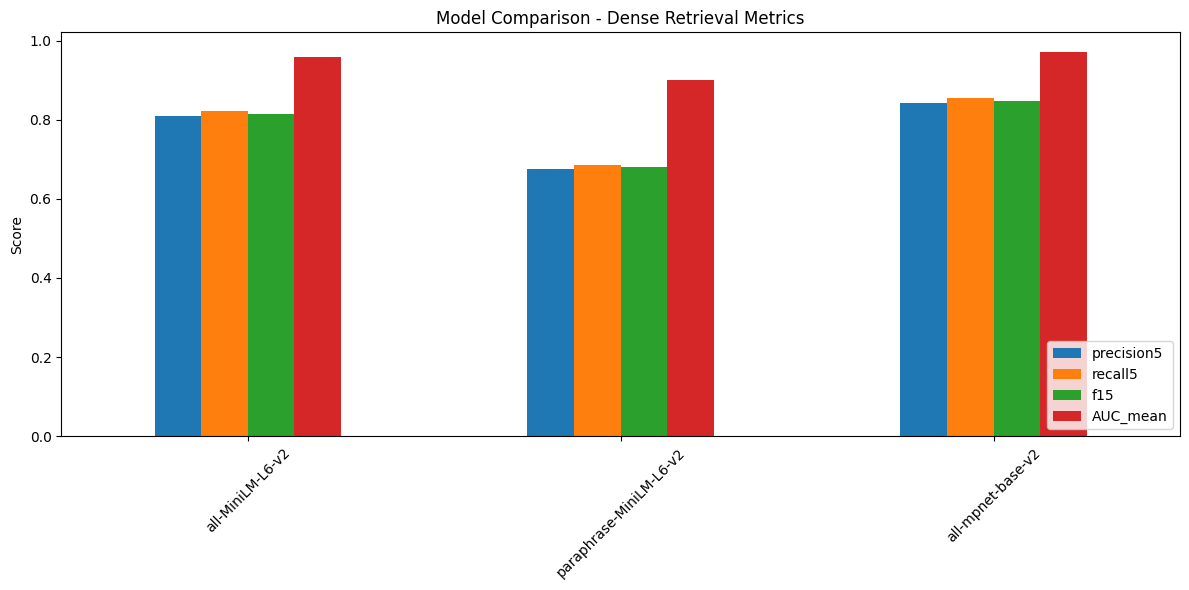

In [29]:
# Visualize comparison
df_comparison.plot(kind='bar', figsize=(12, 6))
plt.title('Model Comparison - Dense Retrieval Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Train LDA topic model

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

lda_vectorizer = CountVectorizer(max_df=0.95, min_df=10, stop_words="english")
X_lda = lda_vectorizer.fit_transform(corpus_texts)
print("LDA document-term matrix shape:", X_lda.shape)

In [ ]:
n_topics = 10
lda_model = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method="batch"
)
lda_model.fit(X_lda)
print("LDA model fitted with", n_topics, "topics")

In [ ]:
def display_topics(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        print("Topic", topic_idx, ":", ", ".join(top_words))

lda_feature_names = lda_vectorizer.get_feature_names_out()
display_topics(lda_model, lda_feature_names, n_top_words=15)


In [ ]:
doc_topic_dist = lda_model.transform(X_lda)
for i in range(5):
    top_topic = doc_topic_dist[i].argmax()
    print("Document", corpus_ids[i], "main topic:", top_topic, "first topic probs:", doc_topic_dist[i][:5])


Construction du graphe de citations

In [ ]:
citation_graph = nx.DiGraph()

for doc_id, doc in corpus.items():
    citation_graph.add_node(doc_id)
    meta = doc.get("metadata", {})

    refs = meta.get("references", [])
    if isinstance(refs, list):
        for ref_id in refs:
            if ref_id in corpus:
                citation_graph.add_edge(doc_id, ref_id)

    cited_by = meta.get("cited_by", [])
    if isinstance(cited_by, list):
        for src_id in cited_by:
            if src_id in corpus:
                citation_graph.add_edge(src_id, doc_id)

print("Citation graph built.")
print("Number of nodes:", citation_graph.number_of_nodes())
print("Number of edges:", citation_graph.number_of_edges())

In [ ]:
n_nodes = citation_graph.number_of_nodes()
n_edges = citation_graph.number_of_edges()
density = nx.density(citation_graph)

in_degrees = np.array([d for _, d in citation_graph.in_degree()])
out_degrees = np.array([d for _, d in citation_graph.out_degree()])

print("Graph density:", density)
print("In-degree mean:", in_degrees.mean(), "variance:", in_degrees.var())
print("Out-degree mean:", out_degrees.mean(), "variance:", out_degrees.var())

In [ ]:
def top_k_nodes(score_dict, k=5):
    return sorted(score_dict.items(), key=lambda x: x[1], reverse=True)[:k]

degree_centrality = nx.degree_centrality(citation_graph)
pagerank_centrality = nx.pagerank(citation_graph, alpha=0.85)
betweenness_centrality = nx.betweenness_centrality(citation_graph, k=500, seed=42)

top_degree = top_k_nodes(degree_centrality, k=5)
top_pagerank = top_k_nodes(pagerank_centrality, k=5)
top_betweenness = top_k_nodes(betweenness_centrality, k=5)

print("Top nodes by degree centrality:")
for doc_id, score in top_degree:
    title = corpus.get(doc_id, {}).get("title", "")
    print(doc_id, "| score:", round(score, 6), "| title:", title)

print("\nTop nodes by PageRank:")
for doc_id, score in top_pagerank:
    title = corpus.get(doc_id, {}).get("title", "")
    print(doc_id, "| score:", round(score, 6), "| title:", title)

print("\nTop nodes by betweenness centrality:")
for doc_id, score in top_betweenness:
    title = corpus.get(doc_id, {}).get("title", "")
    print(doc_id, "| score:", round(score, 6), "| title:", title)


Graph-augmented document representations

In [ ]:
alpha = 0.7

corpus_embeddings_graph = np.zeros_like(corpus_embeddings)

for i, doc_id in enumerate(corpus_ids):
    neighbors = set(citation_graph.predecessors(doc_id)) | set(citation_graph.successors(doc_id))
    neighbors_idx = [corpus_index[n_id] for n_id in neighbors if n_id in corpus_index]
    if len(neighbors_idx) == 0:
        corpus_embeddings_graph[i] = corpus_embeddings[i]
    else:
        neighbor_mean = corpus_embeddings[neighbors_idx].mean(axis=0)
        corpus_embeddings_graph[i] = alpha * corpus_embeddings[i] + (1 - alpha) * neighbor_mean

norms = np.linalg.norm(corpus_embeddings_graph, axis=1, keepdims=True)
nonzero = norms.squeeze() > 0
corpus_embeddings_graph[nonzero] = corpus_embeddings_graph[nonzero] / norms[nonzero]

print("Graph-enhanced embeddings built.")

In [ ]:
old_corpus_embeddings = corpus_embeddings
corpus_embeddings = corpus_embeddings_graph

metrics_graph = evaluate_dense_search(qrels, top_k=5)

corpus_embeddings = old_corpus_embeddings

print("Baseline dense metrics:")
for k, v in metrics_dense.items():
    print(f"{k}: {v:.4f}")

print("\nGraph-enhanced dense metrics:")
for k, v in metrics_graph.items():
    print(f"{k}: {v:.4f}")